In [1]:
import torch
from torcheval.metrics.functional import binary_accuracy
import matplotlib.pyplot as plt
import numpy as np
# Add the directory above the current notebook's directory to the system path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from datasets import load_two_spirals_dataset

### PLot functions

In [2]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    Z = predict(torch.tensor(np.c_[xx.ravel(), yy.ravel()],dtype=torch.float32))
    Z=(Z > 0.5).type(torch.float32)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)

### Import data

torch.Size([1000, 2]) torch.Size([1000, 1])


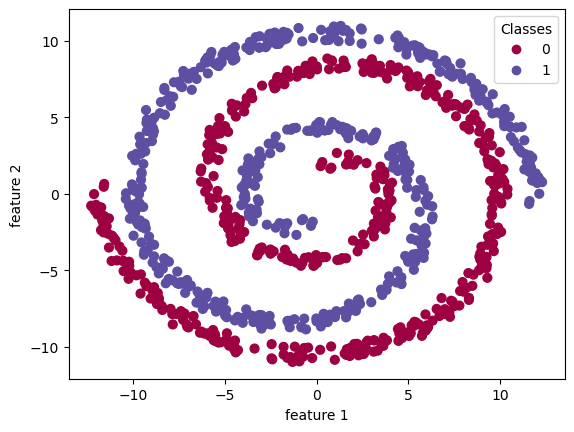

In [3]:
X_np,Y_np = load_two_spirals_dataset(n_points=500, noise=1.0, rev=2.0)
X=torch.tensor(X_np.T, dtype=torch.float32)
Y=torch.tensor(Y_np.reshape(-1,1), dtype=torch.float32)
print(X.shape, Y.shape)
plot_scatter(X_np,Y_np)

### L Layer Neural Network Model

In [4]:
class forward_class(torch.nn.Module):  
    # Constructor
    def __init__(self, layers_dims, activation_L_1="relu", activation_L="sigmoid"):
        super().__init__()
        L = len(layers_dims) # number of layers in the network

        # layers initialized; [1:L-1] X activation_L_1 + [L] X activation_L
        activations = torch.nn.ModuleDict({ 'sigmoid':torch.nn.Sigmoid(), 'tanh':torch.nn.Tanh(),
                'relu':torch.nn.ReLU(), 'lrelu':torch.nn.LeakyReLU() })
        layers_list = []
        for in_f, out_f in zip(layers_dims, layers_dims[1:-1]):
            layers_list.append(torch.nn.Linear(in_f, out_f))
            layers_list.append(activations[activation_L_1])
        layers_list.append(torch.nn.Linear(layers_dims[-2], layers_dims[-1]))
        layers_list.append(activations[activation_L])
        self.l = torch.nn.Sequential(*layers_list)
        
        # weights initialized
        np.random.seed(3)
        with torch.no_grad():
            for l in range(1, L):
                init_W = torch.tensor( np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1]), dtype=torch.float32 )
                init_b = torch.zeros((layers_dims[l], ))
                self.l[2*(l-1)].weight.copy_(init_W)
                self.l[2*(l-1)].bias.copy_(init_b)
    
    # Prediction function
    def forward(self, X):
        yhat = self.l(X)
        return yhat

In [5]:
def L_layer_model(train_X, train_Y, layers_dims, learning_rate=0.0075, num_epochs=2000, activation_L_1="relu", activation_L="sigmoid", print_cost=False):
    """
    L layer neural network with different activation function on output layer option.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    layers_dims : list of int; list of number of nodes in each layer

    Returns
    -------
    forward : trained model
    costs : list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    
    ## Initialize classes
    forward = forward_class(layers_dims, activation_L_1, activation_L)
    bce = torch.nn.BCELoss(reduction='mean')            
    optimizer = torch.optim.Adam(forward.parameters(), lr = learning_rate)

    ## epochs loop
    for i in range(num_epochs): 
        ## forward pass
        train_Y_pred = forward(train_X)       # (209,n_L)=(m,n_L)
        cost = bce(train_Y_pred, train_Y)

        ## backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        ## Record the cost every 100 iterations
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost.item())
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost.item()}")
    
    return forward, costs


def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Detailed info, plots demo

Cost in epochs 1, 0.9791266918182373
Cost in epochs 101, 0.6403278112411499
Cost in epochs 201, 0.568453311920166
Cost in epochs 301, 0.06153872609138489
Cost in epochs 401, 0.009571223519742489
Cost in epochs 501, 0.004327848087996244
Cost in epochs 601, 0.0025730531197041273
Cost in epochs 701, 0.0017303132917732
Cost in epochs 801, 0.0012424883898347616
Cost in epochs 901, 0.0009378340910188854
Cost in epochs 1001, 0.0007323948084376752
Cost in epochs 1101, 0.0005883335252292454
Cost in epochs 1201, 0.0004806343058589846
Cost in epochs 1301, 0.00039717857725918293
Cost in epochs 1401, 0.00033343335962854326
Cost in epochs 1501, 0.0002832742757163942
Cost in epochs 1601, 0.0002432391484035179
Cost in epochs 1701, 0.0002106265164911747
Cost in epochs 1801, 0.0001839027099777013
Cost in epochs 1901, 0.00016164485714398324
Cost in epochs 2000, 0.0001431015698472038
train accuracy: 100.0 %


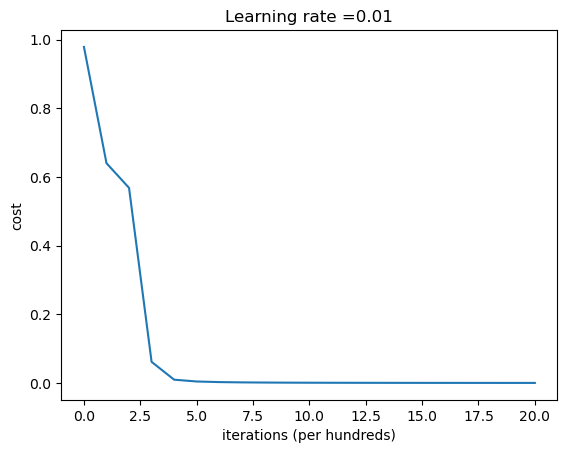

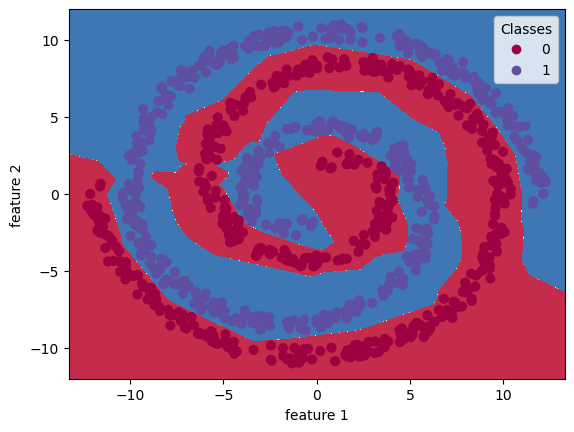

In [6]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],12,12,12, 1]

forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
print(f"train accuracy: { acc.item() *100 } %")
plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)

### Single Neuron Model Run

Cost in epochs 1, 3.921588659286499
Cost in epochs 101, 1.1122806072235107
Cost in epochs 201, 0.657332718372345
Cost in epochs 301, 0.6573050618171692
Cost in epochs 401, 0.6573050618171692
Cost in epochs 501, 0.6573050618171692
Cost in epochs 601, 0.6573050618171692
Cost in epochs 701, 0.6573050618171692
Cost in epochs 801, 0.6573050022125244
Cost in epochs 901, 0.6573050618171692
Cost in epochs 1001, 0.6573050022125244
Cost in epochs 1101, 0.6573050618171692
Cost in epochs 1201, 0.6573050618171692
Cost in epochs 1301, 0.6573050618171692
Cost in epochs 1401, 0.6573050618171692
Cost in epochs 1501, 0.6573050618171692
Cost in epochs 1601, 0.6573050618171692
Cost in epochs 1701, 0.6573050618171692
Cost in epochs 1801, 0.6573050618171692
Cost in epochs 1901, 0.6573050618171692
Cost in epochs 2000, 0.6573050022125244
train accuracy: 59.3999981880188 %


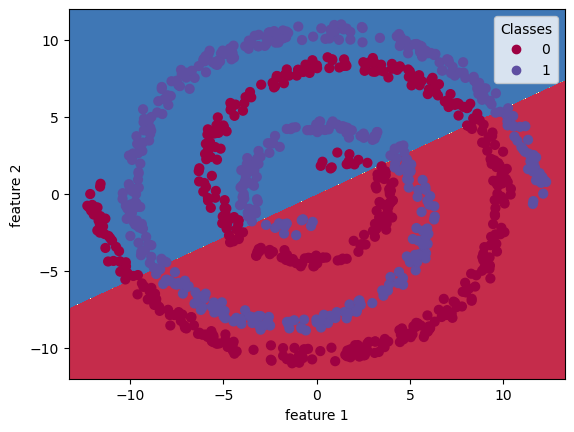

In [7]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1], 1]

forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
print(f"train accuracy: { acc.item() *100 } %")
plot_decision_boundary(forward, X_np, Y_np)

### 2 Layers (or 1 hidden layer) Neural Network with 1 neuron in output layer

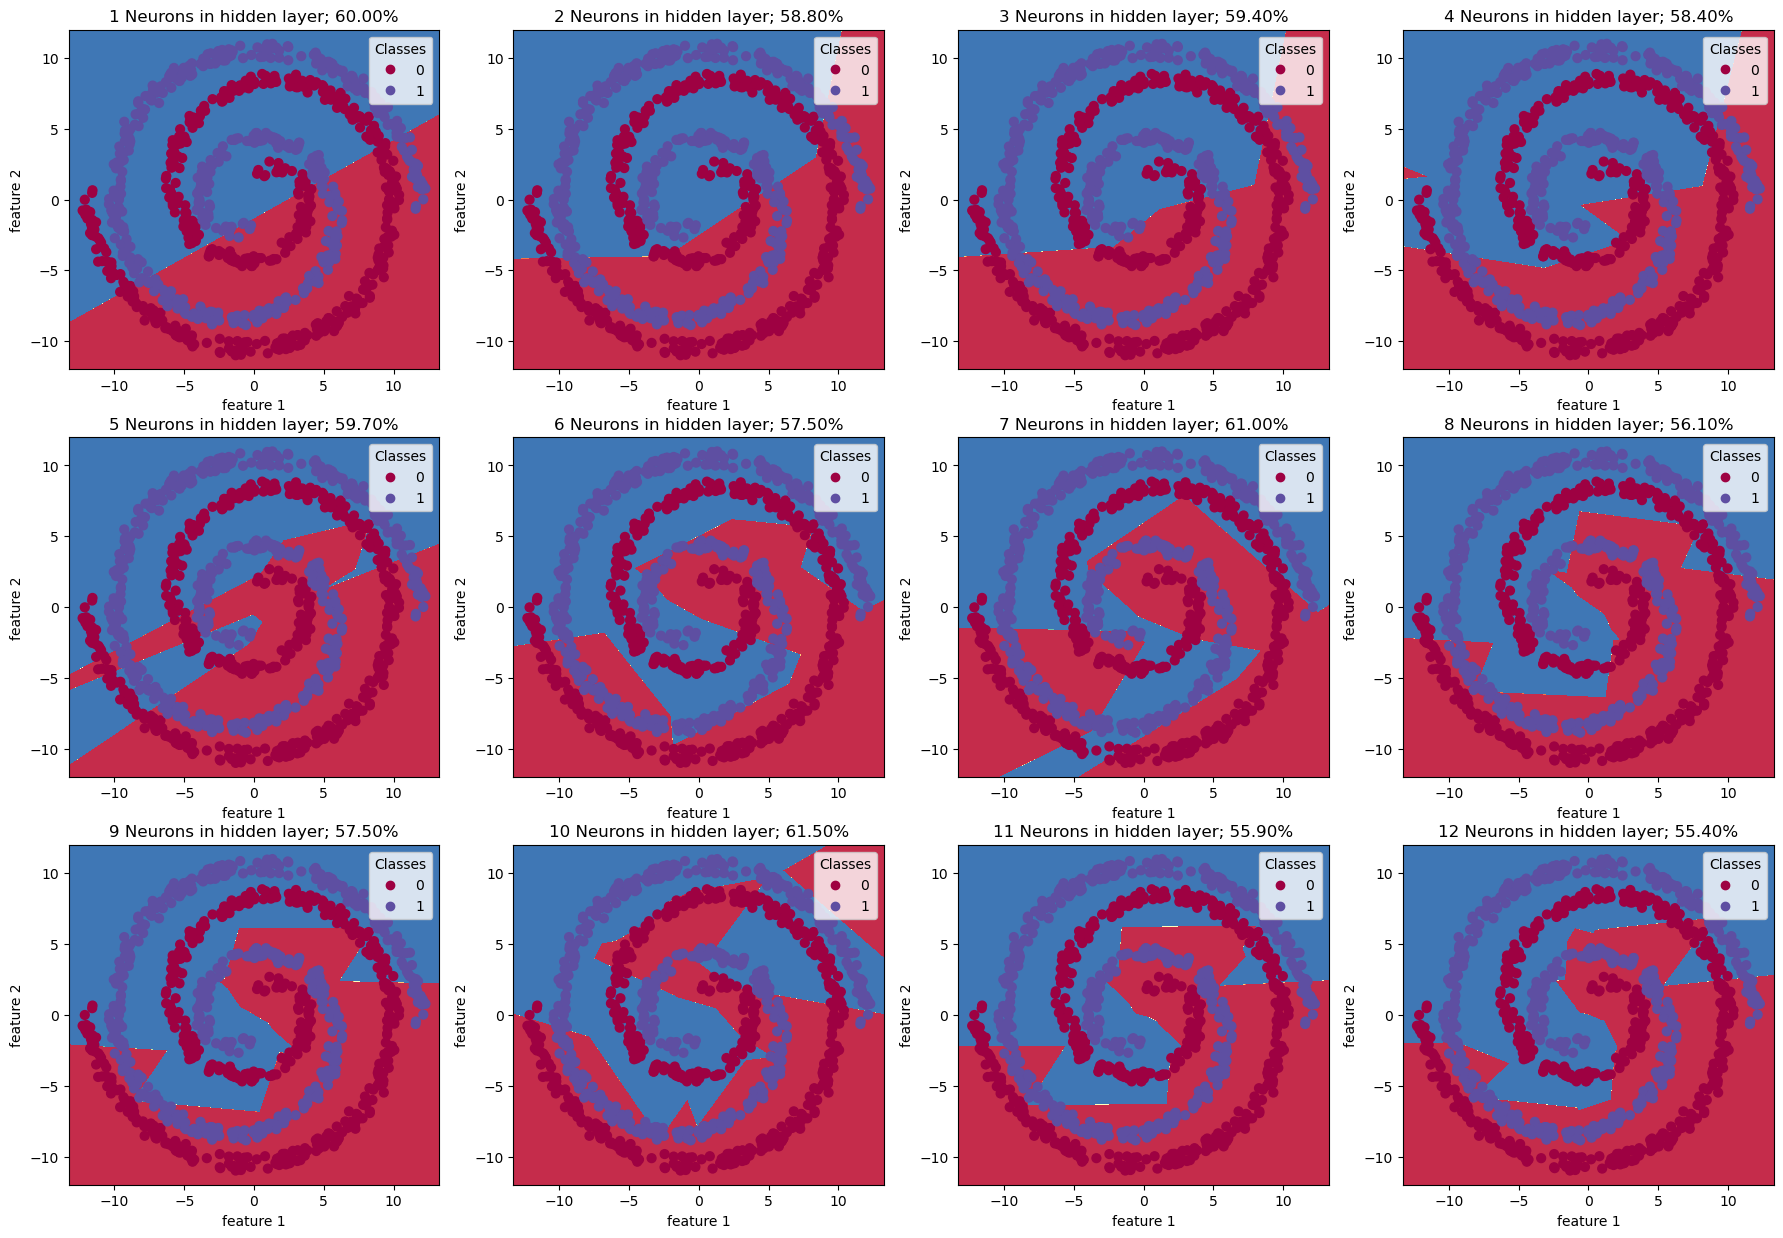

In [8]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"{i} Neurons in hidden layer; {acc.item()*100:.2f}%")


### 3 Layers (or 2 hidden layer) Neural Network with 1 neuron in output layer

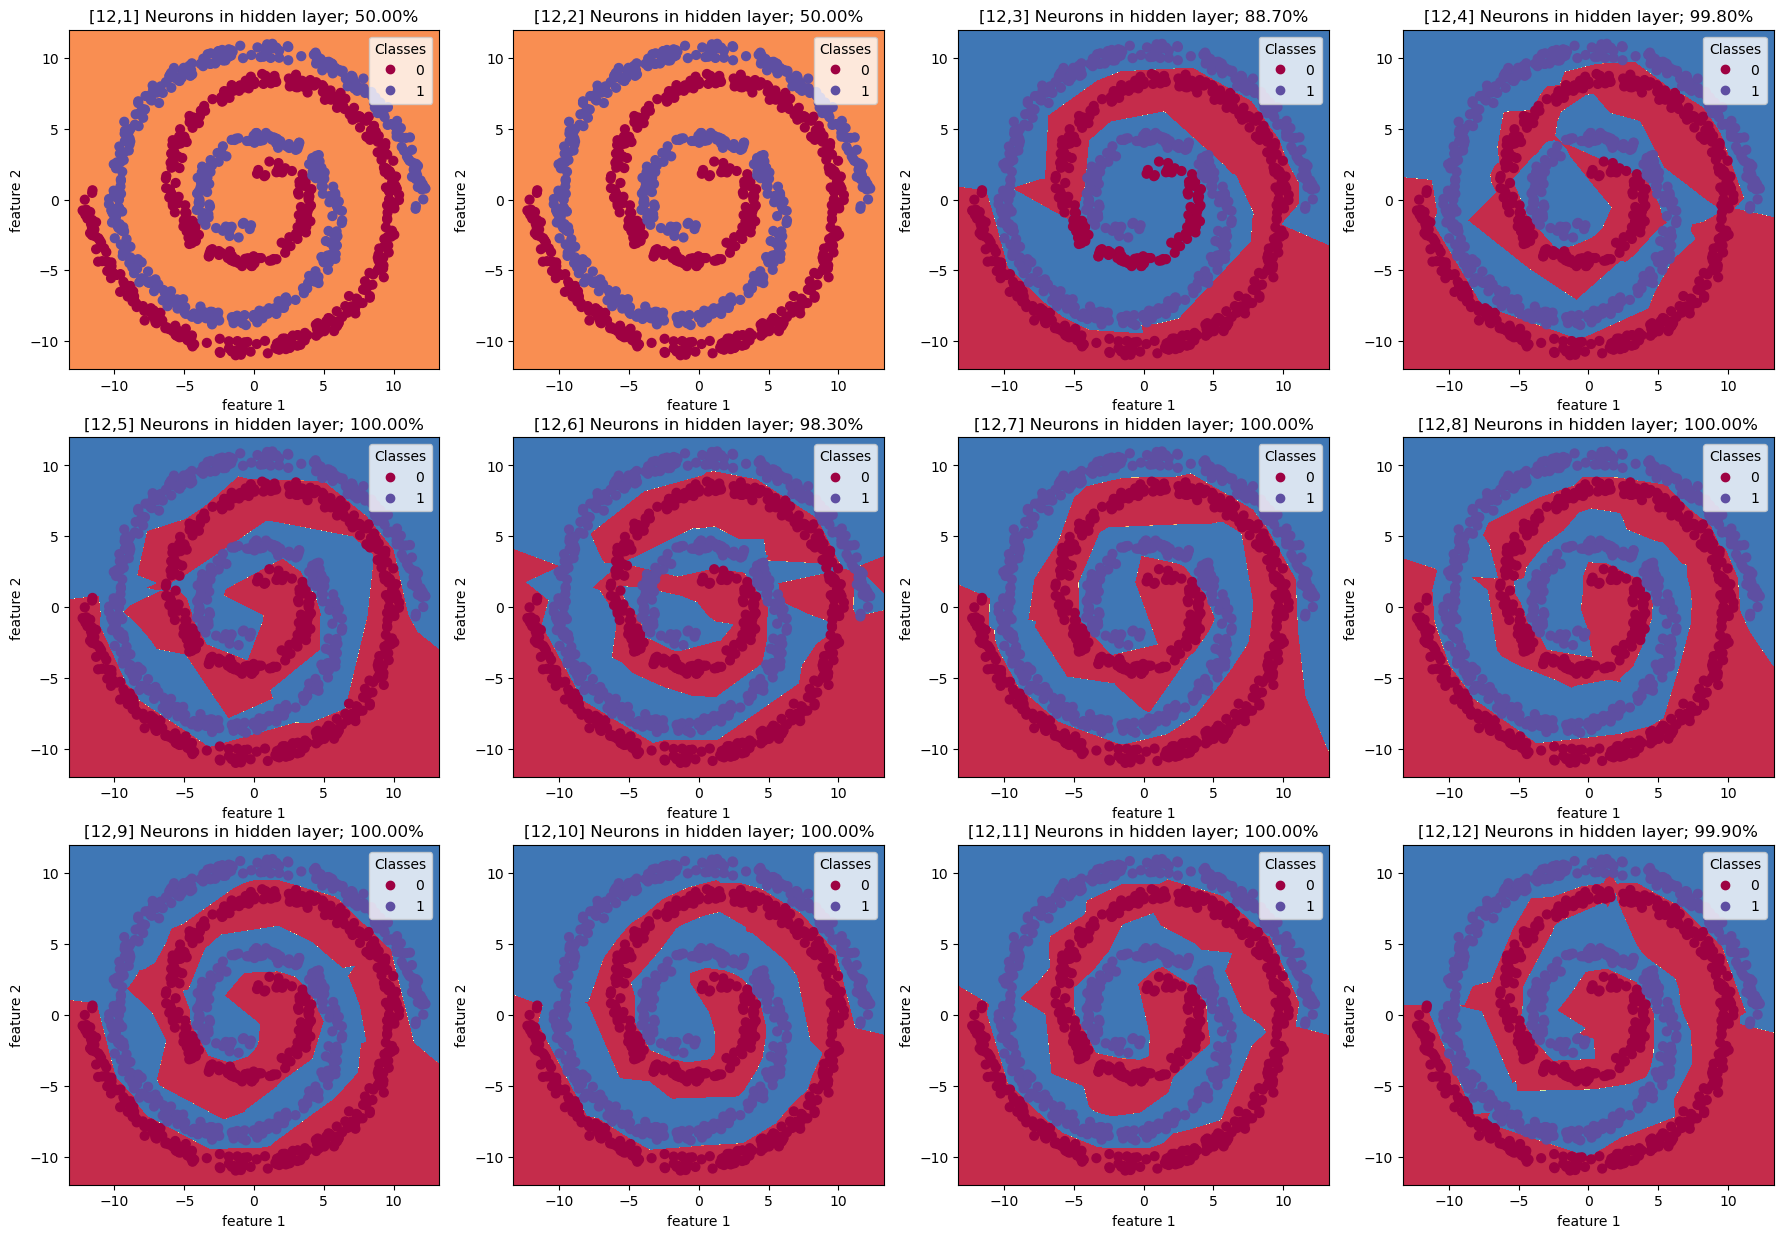

In [9]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],12,1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12, i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[12,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")


### 4 Layers (or 3 hidden layer) Neural Network with 1 neuron in output layer

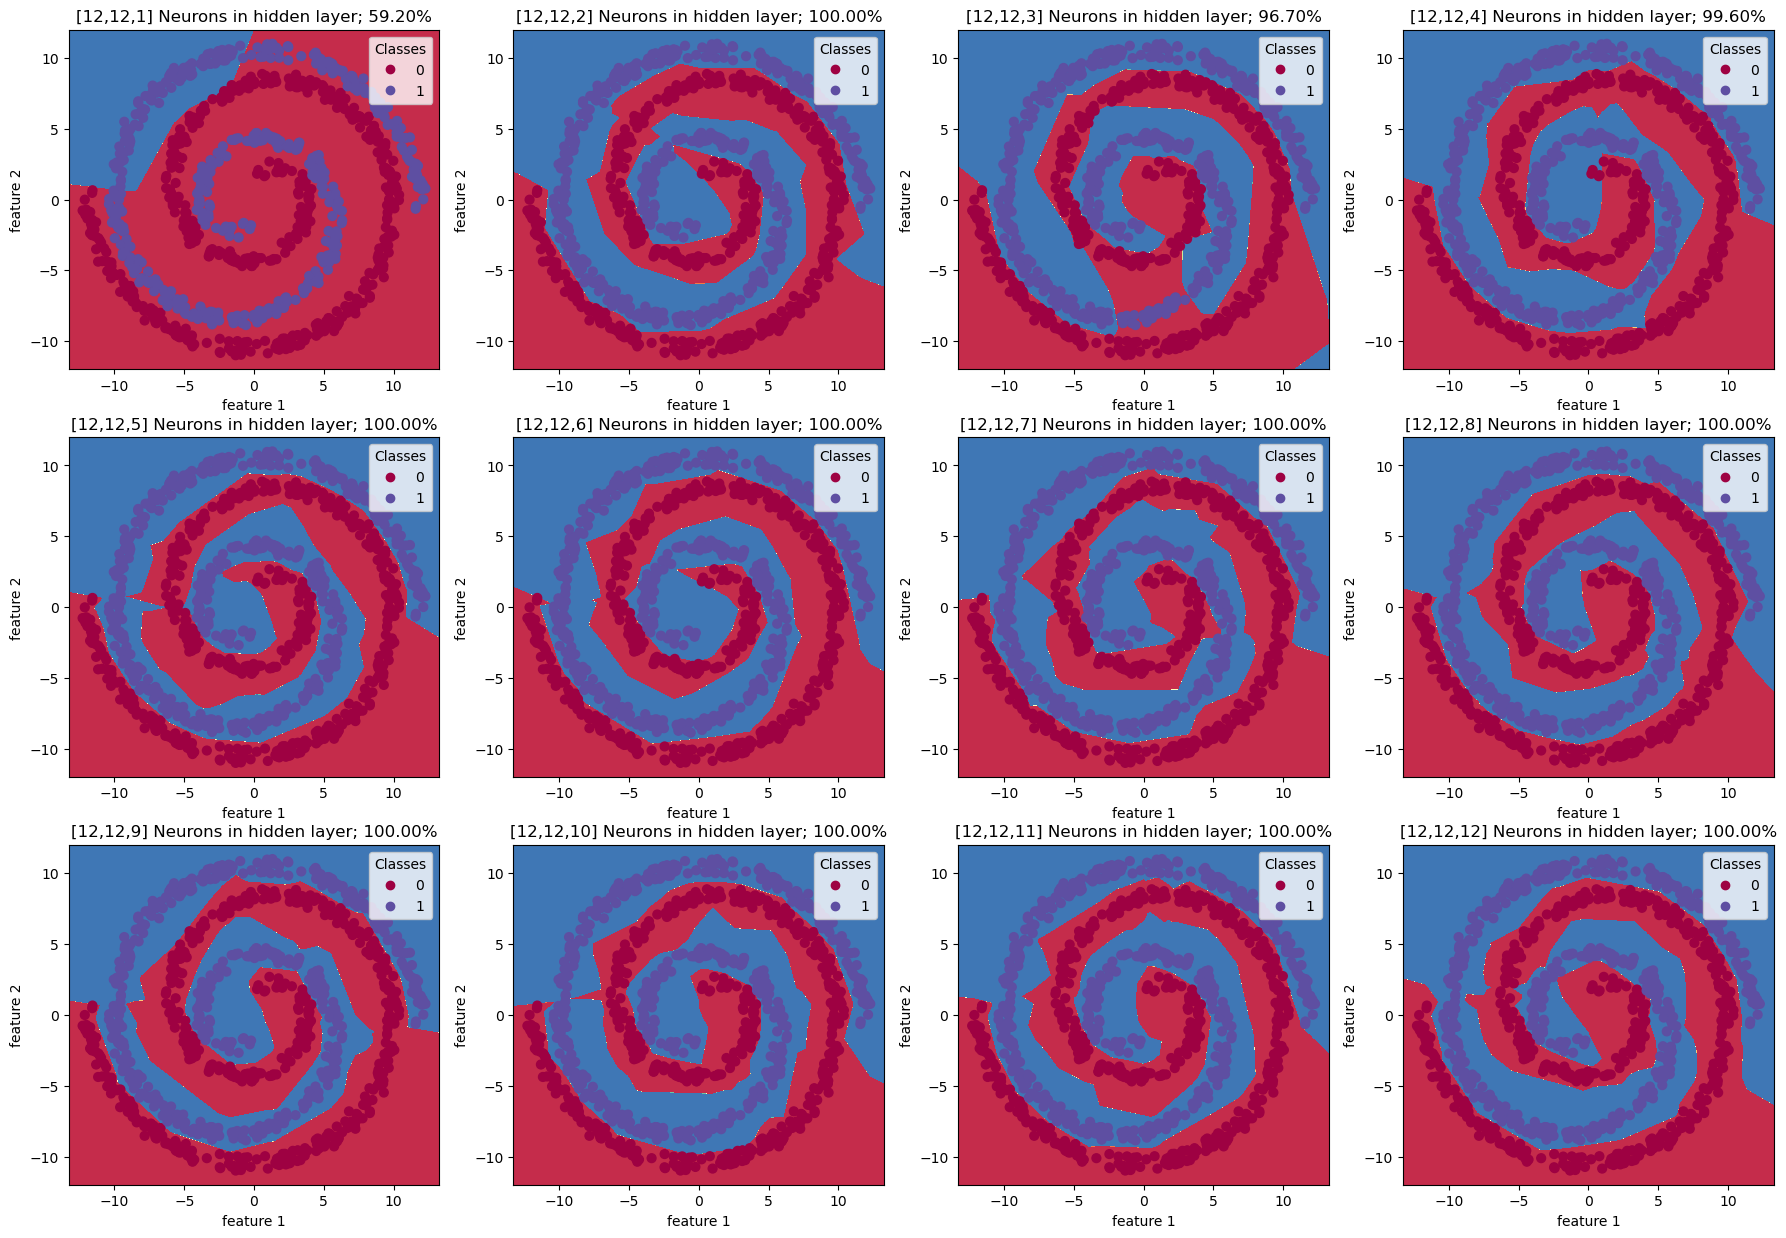

In [10]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],12,12,1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12,12, i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[12,12,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")


### Conclusion

4 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[12,12,12] Neurons in hidden layer; 100.00%')

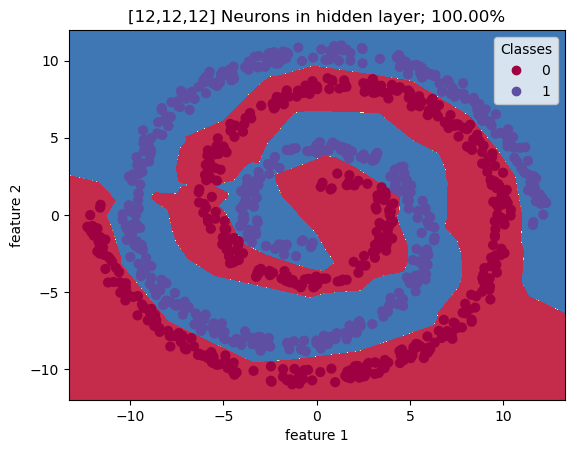

In [11]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],12,12,12, 1]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

layers_dims=[X.shape[-1],12, 12, 12, 1]
forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
plot_decision_boundary(forward, X_np, Y_np)
plt.title(f"[12,12,12] Neurons in hidden layer; {acc.item()*100:.2f}%")